## Run this notebook in Google Colab by clicking here: [Google Colab](https://colab.research.google.com/github/AaronDJohnson/15yr_stochastic_analysis/blob/master/tutorials/bayesian_pe.ipynb)

### Run these cells if using Colab. Otherwise, skip them!

In [ ]:
# This cell will reset the kernel.
# Run this cell, wait until it's done, then run the next.
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()

In [ ]:
%%capture
!mamba install -y -c conda-forge enterprise_extensions la_forge h5pulsar ipympl
!git clone https://github.com/AaronDJohnson/15yr_stochastic_analysis
import sys
# sys.path.insert(0,'/content/15yr_stochastic_analysis/tutorials')

# Using `enterprise` to perform parameter estimation on an isotropic stochastic gravitational wave background with the NANOGrav PTA

In this notebook you will learn:
* How to use `enterprise` to interact with NANOGrav data,

* How to search the full NANOGrav PTA for a common red noise process,

* How to perform parameter estimation on the NANOGrav 15-year data set.

# Load packages and modules

In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import glob, json, sys
import matplotlib.pyplot as plt
import numpy as np

from enterprise.signals import parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals import white_signals
from enterprise.signals import gp_signals

from empirical_distributions import EmpiricalDistribution2D

from enterprise_extensions.models import model_general
from enterprise_extensions import hypermodel
from enterprise_extensions import sampler as ee_sampler

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

from la_forge import core, diagnostics

from h5pulsar.pulsar import FilePulsar

import corner

from matplotlib.widgets import Slider

IN_COLAB = 'google.colab' in sys.modules

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
if IN_COLAB:
    datadir = '/content/12p5yr_stochastic_analysis/tutorials/data'
else:
    datadir = './data'

## Load the full set of Pulsar objects

  * These files have been stored as `HDF5` files to make them much faster to load (and take up little space)
  
  * See the `explore_data.ipynb` tutorial to see what exists in these files and how to load `.par` and `.tim` files

In [3]:
psrs = []
for hdf5_file in glob.glob(datadir + '/hdf5/*.hdf5'):
    psrs.append(FilePulsar(hdf5_file))
print('Loaded {0} pulsars from hdf5 files'.format(len(psrs)))

Loaded 67 pulsars from hdf5 files


## Read in white noise dictionaries
  * We can read-in some previously computed noise properties from single-pulsar white noise analyses. These are things like `EFAC`, `EQUAD`, and (for `NANOGrav`) `ECORR`. 

  * In practice, we set these white-noise properties as fixed in the low-frequency noise / GW searches to reduce the computational cost of the analysis significantly.

  * The noise properties have been stored as `json` files, and are read into a big parameter dictionary.

In [4]:
## Get parameter noise dictionary
noise_ng15 = datadir + '/15yr_wn_dict.json'

wn_params = {}
with open(noise_ng15, 'r') as fp:
    wn_params.update(json.load(fp))

## Set up `enterprise` model for PTA GWB search

  * Here we use `enterprise` directly to describe how we build the GWB model
  
  * Next, we will use `enterprise_extensions` for these common models

In [5]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

* We use the `Selection` object to define which noise parameters are assigned to which chunks of TOAs.

* This selection is based on unique combinations of backends and receivers.
* For example, GUPPI at Green Bank or PUPPI at Arecibo.
* For more information, see the [NANOGrav glossary](https://nanograv.org/glossary)

In [6]:
# define selection by observing backend
selection = selections.Selection(selections.by_backend)

### Priors

* White noise is fixed by using `Constant` parameters.

* In this case we do not specify a default value for all instances of that parameter but instead will set them, based on their initialized pulsar and backend specific name, later via the `set_default_params` method of `PTA`.

* For detection analyses we use a `Uniform` prior on the log of the GWB parameters and intrinsic red noise parameters.

In [7]:
# white noise parameters
efac = parameter.Constant() 
t2equad = parameter.Constant() 
ecorr = parameter.Constant() # we'll set these later with the params dictionary

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.Uniform(-18, -14)('log10_A_gw')
gamma_gw = parameter.Uniform(0, 7)('gamma_gw')

### Signals

* With the priors specified, we now attach them to their associated signals.

* Intrinsic red noise signals are expanded in a Fourier series with frequency bins at $f_i = i/T$ where $i = 1, 2, \ldots, 30$

* 30 is where we choose to stop and not a hard cutoff. This is enough to get the low-frequency content of the data.

* For the GWB, we search over 14 frequencies, because the 14th bin is where a powerlaw with a knee turns up

* The red noise in this model is taken to have a power law PSD

* There are several correlations that we could test against the data.

* These exist in both `enterprise` and `enterprise_extensions` as **overlap reduction functions** or ORFs

* If we want to search for a common uncorrelated red noise (CURN) signal among all pulsars, we use `FourierBasisGP`

* To add in Hellings and Downs (HD) correlations, a detection of which would be indicative of a GWB, we use `FourierBasisCommonGP` and input an `orf`

* Finally, the timing model includes a description of when every pulse will arrive (time of arrival, TOA)

* We set `use_svd=True` to stabilize the timing model

* Timing model uncertainties are marginalized out analytically

In [8]:
# white noise
mn = white_signals.MeasurementNoise(efac=efac, log10_t2equad=t2equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)

# change from 30 to 14 frequencies to line up with the 15 year GWB search
curn = gp_signals.FourierBasisGP(spectrum=cpl, components=14, Tspan=Tspan, name='gw')

# for HD spatial correlations you can do...
# Note that this model is very slow compared to the CURN model above
# orf=utils.hd_orf()
# gwb = gp_signals.FourierBasisCommonGP(cpl, orf=utils.hd_orf(), components=14, Tspan=Tspan, name='gw')

# timing model
tm = gp_signals.MarginalizingTimingModel(use_svd=True)

### Create the full model

* In `enterprise`, we can add signals together to make the full model

* Initializing a `PTA` object with this sum yields the final object.

In [22]:
s = tm + mn + ec + rn + curn

In [23]:
models = []

for p in psrs:
    models.append(s(p))

pta = signal_base.PTA(models)

### Set the constant white noise parameters

In [24]:
pta.set_default_params(wn_params)

## Sample!

* With the PTA model in hand, we are now ready to sample!

* NANOGrav's favorite sampler is `PTMCMCSampler`, a parallel tempering enabled Markov chain Monte Carlo sampler

* This stochastic sampler, uses an adaptive Metropolis-Hastings algorithm to sample the $\mathcal{O}(100)$ dimension PTA parameter space

In [25]:
# set initial parameters drawn from prior
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

In [26]:
# set up the sampler:
# initial jump sample covariance matrix
# this helps decide which point is chosen next and the scale of the problem
cov = np.diag(np.ones(ndim) * 0.01**2)

# set the location to save the output chains
if IN_COLAB:
    outDir = '/content/12p5yr_stochastic_analysis/tutorials/chains/pe_chains'
else:
    outDir = './chains/pe_chains'

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, 
                 outDir=outDir, resume=True)

### Empirical distributions

* Because of the high-dimensional parameter space, it can take a very long time for chains to find the "typical set" of the posterior. This just means the part of the parameter space that the sampler spends the most time in.

* This segment of finding the typical set is often called the "burn-in".

* To significantly reduce the burn-in, we can propose samples from previous analysis runs

* We use the 2D intrinsic red noise posteriors from the noise runs for each individual pulsar

In [27]:
with open(datadir + '/15yr_emp_distr.json', 'r') as fp:
    emp_dists = json.load(fp)

In [28]:
emp_distr = []
for key in emp_dists.keys():
    emp_distr.append(EmpiricalDistribution2D(emp_dists[key]))

In [29]:
%%capture
# add empirical distribution to sampler:
jp = ee_sampler.JumpProposal(pta, empirical_distr=emp_distr)
sampler.addProposalToCycle(jp.draw_from_empirical_distr, 10)  # add empirical distribution draws with weight 10

### Sample!

* Doing this sampling takes many hours to get an adequate amount of samples to approximate the posterior

* While you are welcome to do this yourself, we have included the samples from the posterior

* We can post process these precomputed chains and discuss the results immediately.

In [ ]:
# sampler for N iterations (uncomment the last line if you want to sample this yourself)
# PTMCMCSampler thins the chain by default, so we get 1/10th of the samples we ask for
N = int(5e6)
x0 = np.hstack([p.sample() for p in pta.params])
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

### Post-process with `la_forge`

* `la_forge` uses `core` objects to store MCMC chains from `PTMCMCSampler` into `HDF5` file formats.

* This compresses the chains into a small enough size that they can be easily transferred.

* Here we will look at the `core` that results from the above model. This model involves a common uncorrelated red noise (CURN) process.

In [ ]:
# To load your own chains, include the chain folder's path in core.Core()
# sampled_core = core.Core(outDir)

In [34]:
# set the location to load presampled chains from
if IN_COLAB:
    presampled = '/content/12p5yr_stochastic_analysis/tutorials/presampled_cores'
else:
    presampled = './presampled_cores'

In [35]:
crn_core = core.Core(corepath=presampled + '/curn_14f_pl_vg.core')

* Using the `diagnostics` module, we can test that the chains stay in one place over the duration of the chain with the Rhat diagnostic with `grubin`.

* This is one method to ensure that convergence has been reached (although it is not guaranteed by this test!)

* Additionally, we can check the number of effective samples in the chain with `plot_neff` or plot the marginalized posteriors with `plot_chains`.

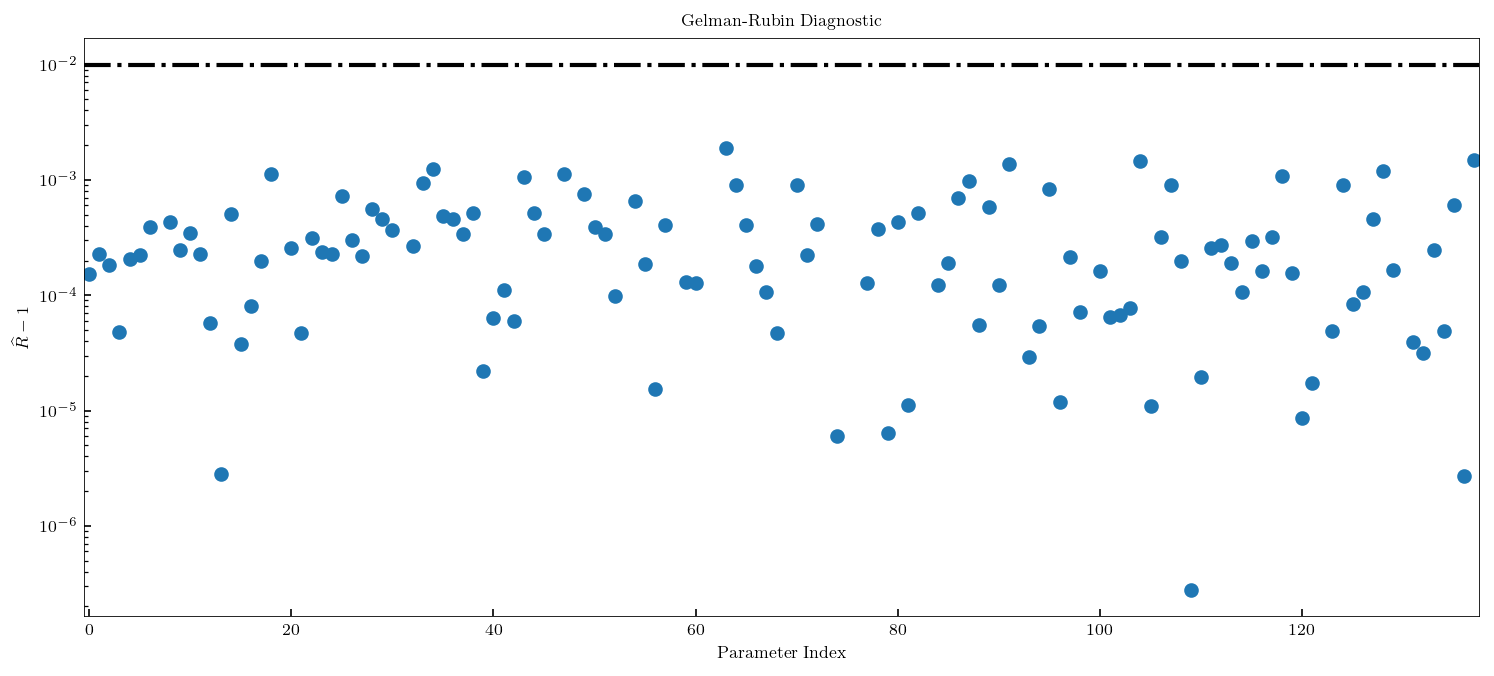

In [67]:
# A threshold of 1.01 suggests that the chain has reached a stationary state
diagnostics.plot_grubin(crn_core)

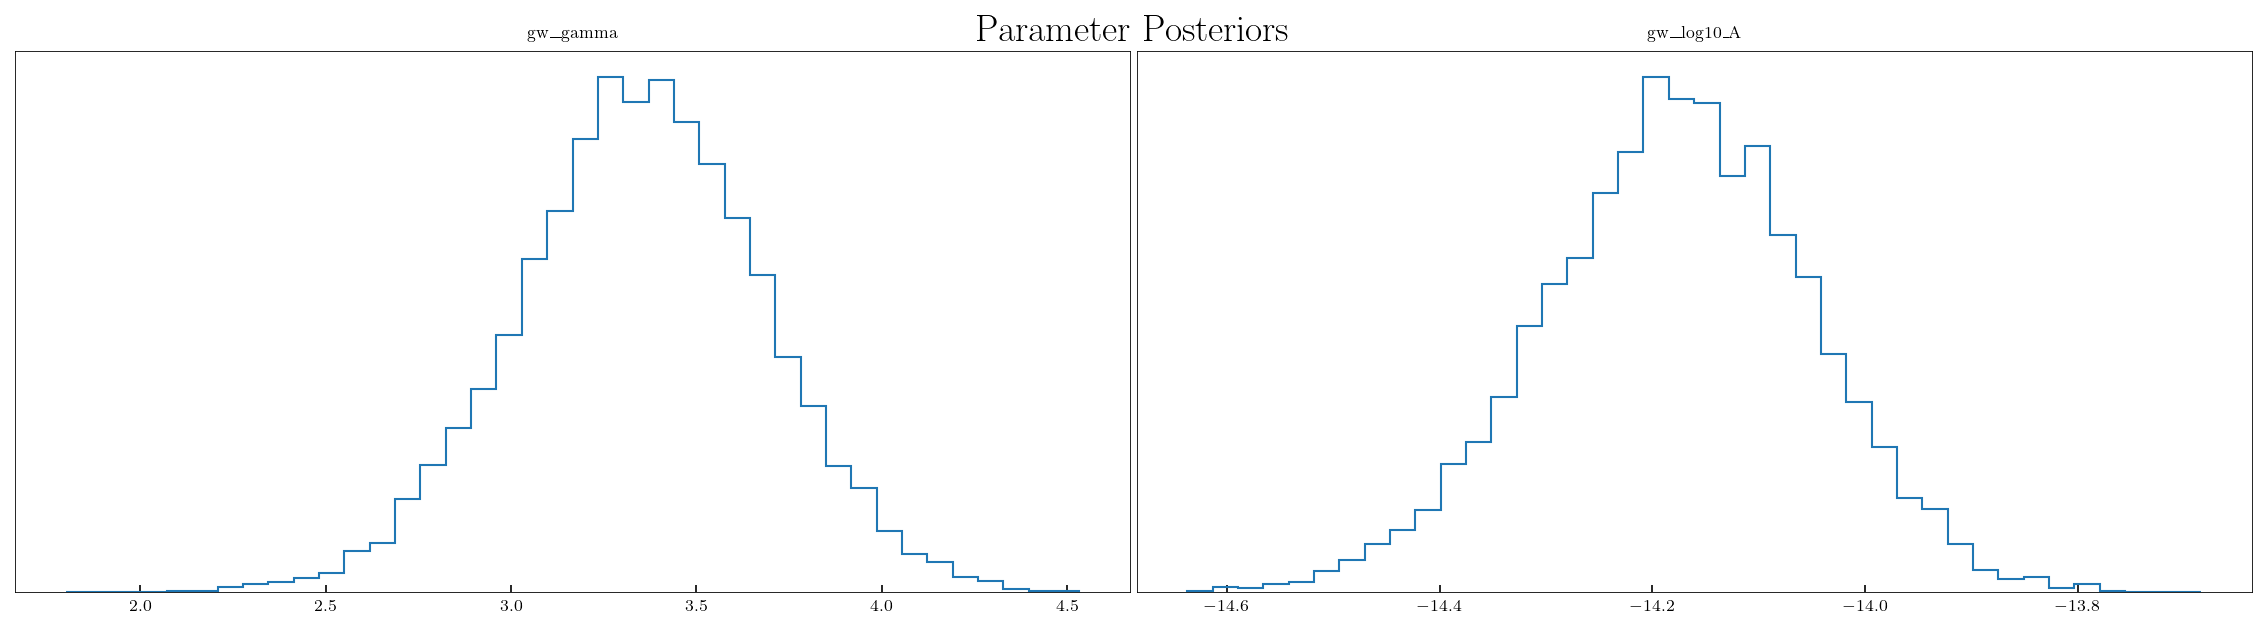

In [72]:
diagnostics.plot_chains(crn_core, pars=['gw__gamma', 'gw__log10_A'], ncols=2)

* To plot the joint posterior for these two parameters, we use `corner`

* Typically, the reference frequency is set to $1/\mathrm{ yr}$, but in this case, we also plot $1/10\mathrm{yr}$

* When the reference frequency is set to $\mathrm{yr}^{-1}$, the amplitude ($\log_{10}A$) and spectral index ($\gamma$) appear correlated, but this disappears when we set $f_{\mathrm{ref}}$ to a more sensitive frequency.

* PTAs are not sensitive to frequencies of $\mathrm{yr}^{-1}$ due to fitting of proper motion and pulsar position parameters in the timing model

* A vertical line at $\gamma = 13/3$ indicates the spectral index that is expected for an ensemble of supermassive black hole binaries emitting gravitational waves. Lower $\gamma$ is indicative of potential environmental effects nearby such binaries.

In [39]:
joint_1yr = np.array([crn_core.get_param('gw__gamma'), crn_core.get_param('gw__log10_A')]).T

In [112]:
def joint_correction(yrs):
    correction = 0.5 * (3 - crn_core.get_param('gw__gamma')) * np.log10(1/yrs)
    joint = correction + crn_core.get_param('gw__log10_A')
    return joint

# change 10 in the next line to the number of years you want to see how it affects the correlation!
joint_10yr = np.array([crn_core.get_param('gw__gamma'), joint_correction(10)]).T

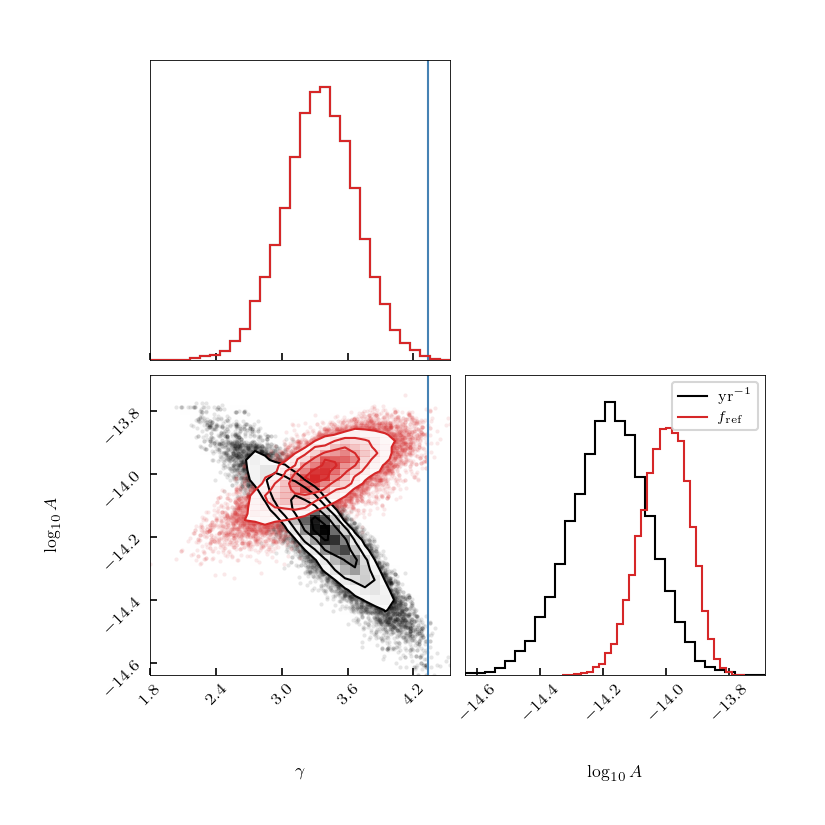

In [113]:
fig = corner.corner(joint_1yr, truths=[13/3, None], bins=30, color='black', labels=[r'$\gamma$', r'$\log_{10}A$'])
corner.corner(joint_10yr, bins=30, color='C3', fig=fig)
plt.plot([], [], color='black', label=r'$\mathrm{yr}^{-1}$')
plt.plot([], [], color='C3', label=r'$f_\mathrm{ref}$')
plt.legend()

plt.show()

## Free spectrum analysis

* This model includes 30 frequency bins at $f_i / T$ and allows each of the frequency bins to be freely modeled.

* To create such a model, we will use `enterprise_extensions` to easily create common models.

* `model_general` takes several arguements, the ones which we use here are:
  * psrs: pulsars we want in the PTA
  * noisedict: white noise parameters to be set for constant parameters
  * common_components: number of frequencies to use in the common signals
  * tm_svd: use SVD on the timing model design matrix (a good idea in general)
  * orf: overlap reduction function (correlation function such as HD correlations)
  * common_psd: model used for the common signals
  * tm_marg: use two-step marginalization (good for constant white noise)


In [95]:
pta = model_general(psrs, noisedict=wn_params, common_components=30, tm_svd=True,
                    orf='hd', common_psd='spectrum', tm_marg=True)

In [100]:
%%capture
outdir = './chains/pe_free_spec'
sampler = ee_sampler.setup_sampler(pta, outdir=outdir, empirical_distr=emp_distr, resume=True)

In [101]:
# sampler for N iterations (uncomment the last line if you want to sample this yourself)
# PTMCMCSampler thins the chain by default, so we get 1/10th of the samples we ask for
N = int(5e6)
x0 = np.hstack([p.sample() for p in pta.params])
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [119]:
hd_fs_core = core.Core(corepath=presampled + '/hd_30f_fs.core')